
# Satire Classification: Machine Learning Models


In the provided notebook, we embarked on a journey to classify articles as satire or genuine. We began by loading and preprocessing the dataset, which consisted of articles labeled as either "satire" or "true". We also integrated additional satire articles from "The Onion" to enhance the training set. Following this, we split the data into a training set and a validation set, retaining 80% of the data for training and 20% for validation purposes.

Two preliminary machine learning models were employed: a Logistic Regression model and a Random Forest classifier. We plan to move towards more advanced models in future weeks. Both models were trained using a TF-IDF vectorizer for text representation. TF-IDF stands for Term Frequency-Inverse Document Frequency, and it's a numerical statistic that reflects how important a word is to a document within a collection or corpus. The TF-IDF value for a word increases proportionally to the number of times the word appears in the document but is offset by the frequency of the word in the corpus. This helps to adjust for the fact that some words appear more frequently in general and might not be particularly meaningful in distinguishing between different types of texts. After training, we evaluated the models on the validation set to understand their performance.

For a more comprehensive understanding of the models' efficacy, we visualized the results. Confusion matrices provided insights into the number of correct and incorrect predictions, while a bar chart comparison displayed key metrics, including accuracy, precision, recall, and F1-score, for both models. The models performed remarkably similarly, doing very well correctly assigning the true label to true articles, but poorly in classifying satire articles as satire.

Finally, we sought to understand which features/tokens were most important for our models when they attempted to classify the articles. We plotted bar charts showing these important tokens.

In [ ]:

# Load and preprocess the dataset

import os
import zipfile
import pandas as pd

# Path to the dataset. Make sure to upload zip file and rename to satire.zip
zip_path_new = 'satire.zip'
unzip_dir_new = 'satire_unzipped.zip'

with zipfile.ZipFile(zip_path_new, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir_new)

# Define paths
satire_dir_new = os.path.join(unzip_dir_new, "satire")
training_path_new = os.path.join(satire_dir_new, "training")
training_class_path_new = os.path.join(satire_dir_new, "training-class")

# Load training labels
with open(training_class_path_new, 'r', encoding='utf-8', errors='ignore') as file:
    training_labels_new = [line.strip().split() for line in file.readlines()]

# Mapping of filenames to labels
label_map_new = {filename: label for filename, label in training_labels_new}

# Load training examples
training_data_new = []
for filename, label in training_labels_new:
    file_path = os.path.join(training_path_new, filename)
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
        content = file.read()
        training_data_new.append({
            "filename": filename,
            "content": content,
            "label": label
        })

# Convert to DataFrame for easier analysis
training_df_new = pd.DataFrame(training_data_new)

# Load "The Onion" articles
theonion_dir = os.path.join(satire_dir_new, "theonion_articles")
theonion_data = []
for filename in os.listdir(theonion_dir):
    file_path = os.path.join(theonion_dir, filename)
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
        content = file.read()
        theonion_data.append({
            "filename": filename,
            "content": content,
            "label": "satire"
        })

# Convert to DataFrame and append to the main training DataFrame
theonion_df = pd.DataFrame(theonion_data)
training_df_extended = pd.concat([training_df_new, theonion_df], ignore_index=True)

# Convert label column to binary format (1 for satire, 0 for true)
training_df_extended['label'] = training_df_extended['label'].map({'satire': 1, 'true': 0})

# Display the first few rows
training_df_extended.head()


,filename,content,label
0,training-0001,"G7 meeting seen as ""dollar's last hope"" \n\...",0
1,training-0002,NZ Government Signs Land Deal with Maoris \...,0
2,training-0003,Saudi man suffocates in bid for freedom \n\...,0
3,training-0004,News Analysis: Thai PM-Apparent Faces Tough...,0
4,training-0005,China Expands Foreign Cooperation in Onshor...,0


In [ ]:
training_df_extended.value_counts("label")

label
0    2505
1     177
dtype: int64

In [ ]:
sampled_class_1_data = training_df_extended[training_df_extended['label'] == 1]
sampled_class_0_data = training_df_extended[training_df_extended['label'] == 0].sample(n=len(sampled_class_1_data), random_state=42)
balanced_df = pd.concat([sampled_class_0_data, sampled_class_1_data])

# Shuffle data
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# Train-Validation Split

from sklearn.model_selection import train_test_split

# Split the data into training and validation sets (80% train, 20% validation)
#train_df, val_df = train_test_split(training_df_extended, test_size=0.2, stratify=training_df_extended['label'], random_state=42)
train_df, val_df = train_test_split(balanced_df, test_size=0.2, random_state=42)

train_df.shape, val_df.shape


((283, 3), (71, 3))

In [ ]:

# Text Vectorization and Model Training

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Create pipelines for both models
logistic_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
    ('clf', LogisticRegression(solver='liblinear'))
])

rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
    ('clf', RandomForestClassifier())
])

# Train the models
logistic_pipeline.fit(train_df['content'], train_df['label'])
rf_pipeline.fit(train_df['content'], train_df['label'])

"Models trained successfully"


'Models trained successfully'

In [ ]:

# Model Evaluation on Validation Data

from sklearn.metrics import classification_report

# Predictions
logistic_preds = logistic_pipeline.predict(val_df['content'])
rf_preds = rf_pipeline.predict(val_df['content'])

# Evaluation
logistic_report = classification_report(val_df['label'], logistic_preds)
rf_report = classification_report(val_df['label'], rf_preds)

logistic_report


'              precision    recall  f1-score   support\n\n           0       0.91      0.94      0.93        34\n           1       0.94      0.92      0.93        37\n\n    accuracy                           0.93        71\n   macro avg       0.93      0.93      0.93        71\nweighted avg       0.93      0.93      0.93        71\n'

In [ ]:
rf_report

'              precision    recall  f1-score   support\n\n           0       0.74      0.85      0.79        34\n           1       0.84      0.73      0.78        37\n\n    accuracy                           0.79        71\n   macro avg       0.79      0.79      0.79        71\nweighted avg       0.80      0.79      0.79        71\n'

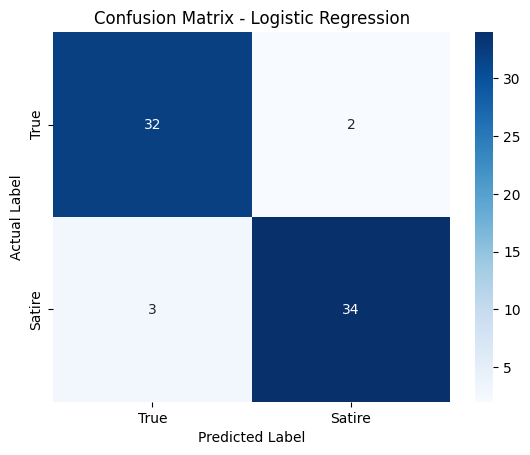

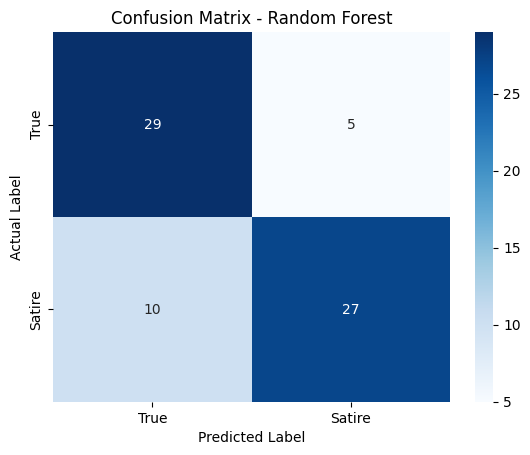

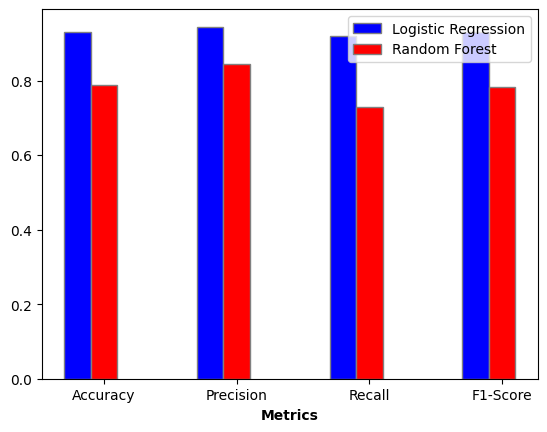

In [ ]:
# Visualization of Results

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title):
    matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['True', 'Satire'], yticklabels=['True', 'Satire'])
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.title(title)
    plt.show()

def plot_metrics_comparison(metrics, model_names):
    barWidth = 0.2
    r1 = np.arange(len(metrics[model_names[0]]))
    r2 = [x + barWidth for x in r1]

    plt.bar(r1, metrics[model_names[0]], color='b', width=barWidth, edgecolor='grey', label=model_names[0])
    plt.bar(r2, metrics[model_names[1]], color='r', width=barWidth, edgecolor='grey', label=model_names[1])

    plt.xlabel('Metrics', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(metrics[model_names[0]]))], ['Accuracy', 'Precision', 'Recall', 'F1-Score'])
    plt.legend()
    plt.show()

# Get metrics
logistic_metrics = [
    np.mean(logistic_preds == val_df['label']),
    precision_score(val_df['label'], logistic_preds),
    recall_score(val_df['label'], logistic_preds),
    f1_score(val_df['label'], logistic_preds)
]

rf_metrics = [
    np.mean(rf_preds == val_df['label']),
    precision_score(val_df['label'], rf_preds),
    recall_score(val_df['label'], rf_preds),
    f1_score(val_df['label'], rf_preds)
]

metrics = {
    'Logistic Regression': logistic_metrics,
    'Random Forest': rf_metrics
}

# Plot confusion matrices
plot_confusion_matrix(val_df['label'], logistic_preds, "Confusion Matrix - Logistic Regression")
plot_confusion_matrix(val_df['label'], rf_preds, "Confusion Matrix - Random Forest")

# Plot metrics comparison
plot_metrics_comparison(metrics, ['Logistic Regression', 'Random Forest'])


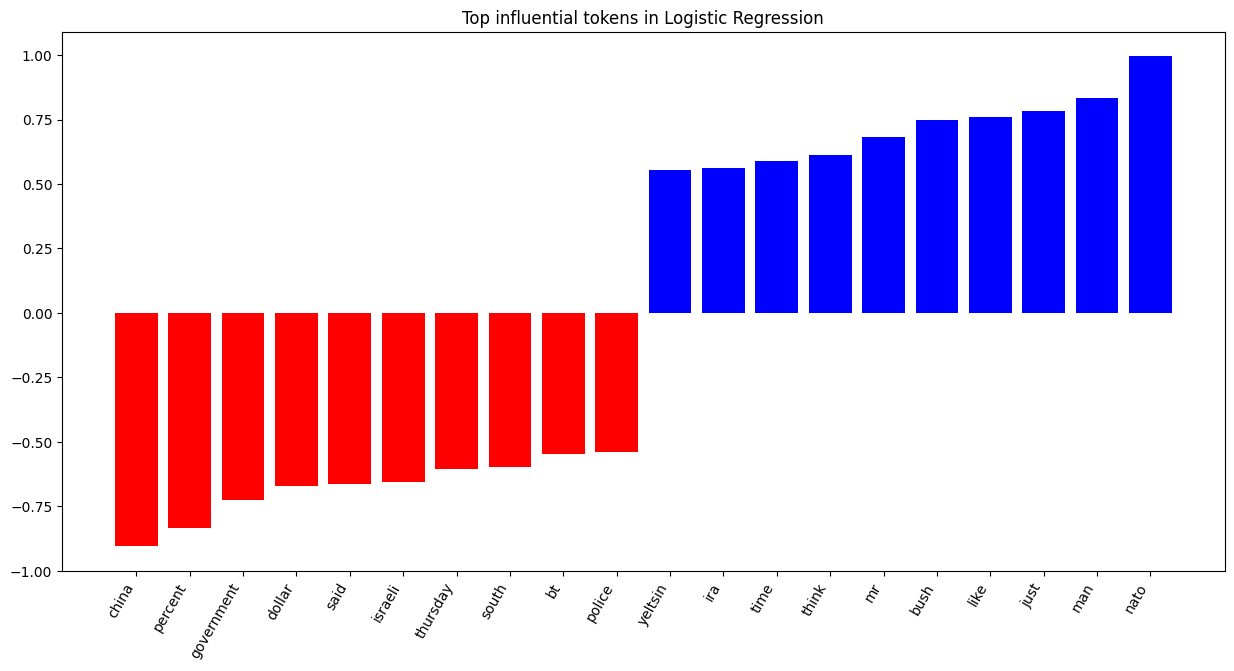

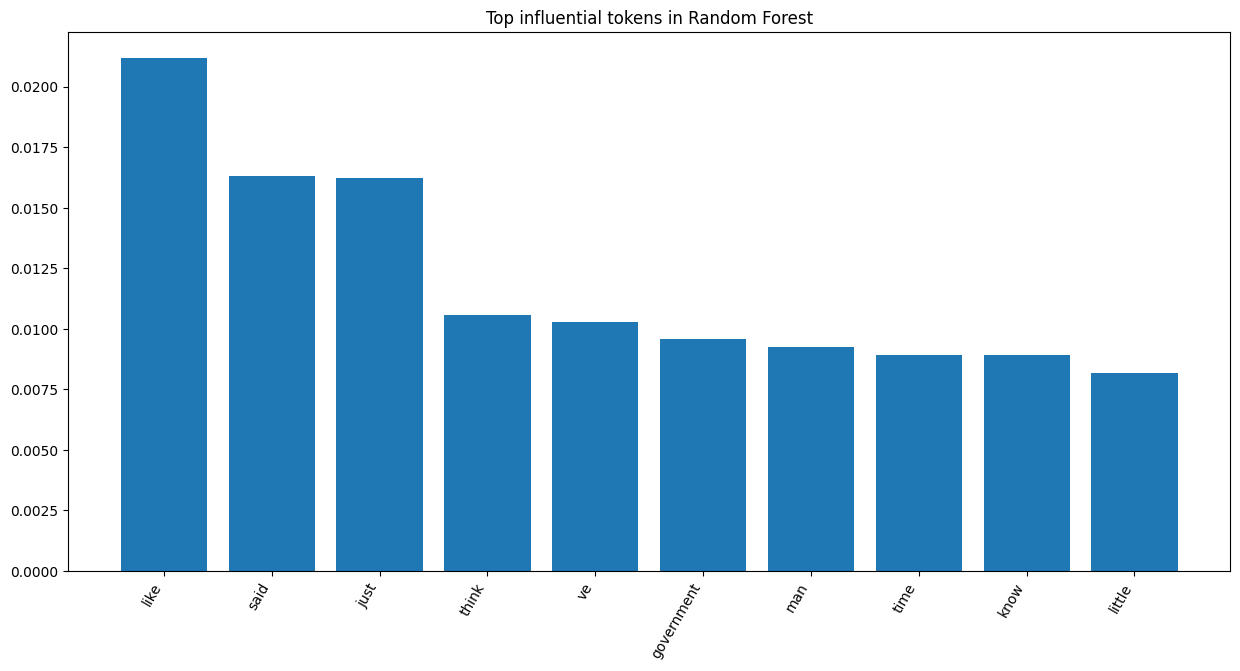

In [ ]:
import matplotlib.pyplot as plt

def plot_top_features(model, vectorizer, top_n=10):
    """Plot top features for classification."""
    # Get feature names
    feature_names = vectorizer.get_feature_names_out()

    # Get top feature coefficients for Logistic Regression
    if hasattr(model, "coef_"):
        # Sort the coefficients
        sorted_coef_index = model.coef_[0].argsort()
        # Get top and bottom coefficients (words)
        top_positive_coefficients = sorted_coef_index[-top_n:]
        top_negative_coefficients = sorted_coef_index[:top_n]
        top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])

        # Plot
        plt.figure(figsize=(15, 7))
        colors = ['red' if coef < 0 else 'blue' for coef in model.coef_[0][top_coefficients]]
        plt.bar(np.arange(2 * top_n), model.coef_[0][top_coefficients], color=colors)
        plt.xticks(np.arange(2 * top_n), np.array(feature_names)[top_coefficients], rotation=60, ha='right')
        plt.title("Top influential tokens in Logistic Regression")
        plt.show()

    # Get feature importances for Random Forest
    elif hasattr(model, "feature_importances_"):
        sorted_importances_index = model.feature_importances_.argsort()[-top_n:][::-1]

        # Plot
        plt.figure(figsize=(15, 7))
        plt.bar(np.arange(top_n), model.feature_importances_[sorted_importances_index])
        plt.xticks(np.arange(top_n), np.array(feature_names)[sorted_importances_index], rotation=60, ha='right')
        plt.title("Top influential tokens in Random Forest")
        plt.show()
    else:
        print("Model not supported!")

# Extract vectorizer and trained models from the pipelines
tfidf_vectorizer = logistic_pipeline.named_steps['tfidf']
logistic_model = logistic_pipeline.named_steps['clf']
rf_model = rf_pipeline.named_steps['clf']

# Plot top features for both models
plot_top_features(logistic_model, tfidf_vectorizer)
plot_top_features(rf_model, tfidf_vectorizer)


**Logistic Regression:**

The graph for Logistic Regression displays the coefficients of the model for different tokens (words). The coefficients indicate the importance and direction of each feature's effect:

Positive Coefficients (Blue Bars): These tokens increase the log-odds of the output being classified as 'satire'. In other words, when these tokens appear in an article, the model is more likely to classify it as satire. The height of the blue bar indicates the strength of this association. Taller blue bars mean that the presence of that token strongly suggests the article is satirical.

Negative Coefficients (Red Bars): These tokens decrease the log-odds of the output being classified as 'satire', making it more likely for the model to classify the article as genuine (or true). The depth of the red bar indicates the strength of this association. Deeper red bars mean that the presence of that token strongly suggests the article is genuine.



**Random Forest:**

The graph for Random Forest displays feature importances. Feature importance gives you a score for each feature of your data, with higher scores indicating more important or more decisive features for the output variable.

Feature Importances (Blue Bars): The height of these bars indicates the importance of each token in the decision-making process of the Random Forest. Tokens with taller bars are more influential in the model's decision. This doesn't tell you the direction of the influence (i.e., whether the token suggests satire or genuine), but it tells you which tokens are most valuable in differentiating between classes.

(Random Forest, being an ensemble of decision trees, does not produce coefficients like logistic regression. Instead, it uses a measure called "feature importance" to indicate how useful or valuable each feature was in the construction of the decision trees within the model.)